In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr

from plot_utils import plot_ground_truth_heatmap, plot_col_color_heatmap

{'seed': 1, 'n_samps': 1500, 'z_param': {'spike_grp': ['left', 'mid', 'right'], 'n_repetitions': 1, 'rel_noise_list': [0.1, 0.1]}, 'x_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 150, 'rel_noise_list': [0.1], 'seed_offset': 0}, 'n_trials': 100, 'noise_levs': [], 'sparsities': [], 'target_vars': 5994, 'methods': ['unsup_graph', 'graph'], 'graph_k': 10, 'n_perms': 10000, 'alpha': 0.05, 'perm_method': 'pool', 'sim_dir': '/share/PI/sabatti/feat_viz/corr_sim/regime_1', 'save': True, 'check_skip': False, 'null_struct': {'model': 'normal', 'block_size': 150, 'corr_value': 0.4, 'scale': 0.5, 'seed': 10}, 'method_params': {'method': 'graph', 'n_perms': 10000, 'perm_method': 'pool', 'alpha': 0.05, 'graph_k': 10}}


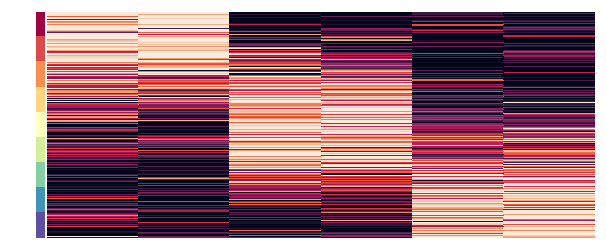

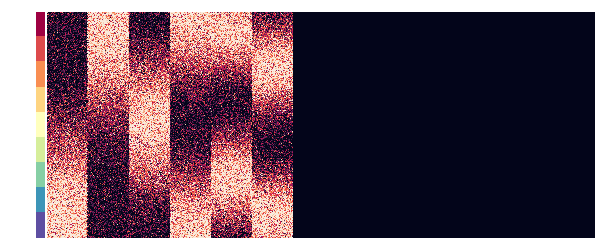

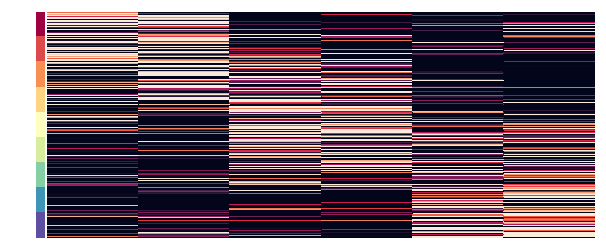

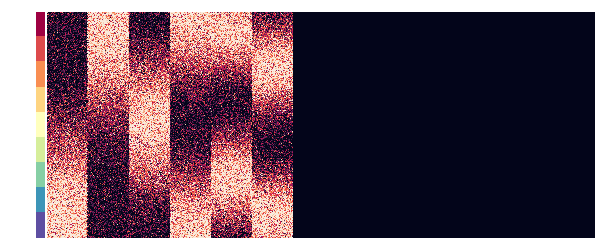

In [15]:
from sim_utils import get_corr_sim, generate_invariant_data, model_corr_noise
from plot_utils import plot_ground_truth_heatmap, plot_spike_grps

sim_params = get_corr_sim(regime=1)
print(sim_params)
# generate invariant data
lam_true, z_init, x_init, var_df = generate_invariant_data(sim_params)
plot_ground_truth_heatmap(lam_true, z_init)
plot_ground_truth_heatmap(lam_true, x_init[:,:2000])
z, x, v_df = model_corr_noise(sim_params['null_struct'], z_init, x_init)
var_df = pd.concat([var_df, v_df], axis=1)
# mtx = np.concatenate([z, x], axis=1)
# n_lm_genes = z.shape[1]
plot_ground_truth_heatmap(lam_true, z)
plot_ground_truth_heatmap(lam_true, x_init[:,:2000])

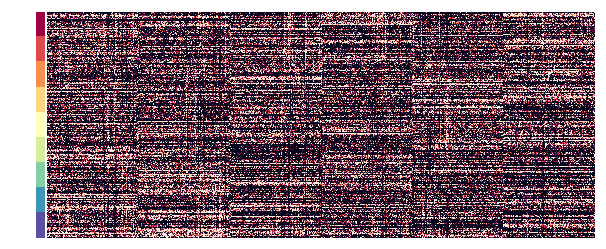

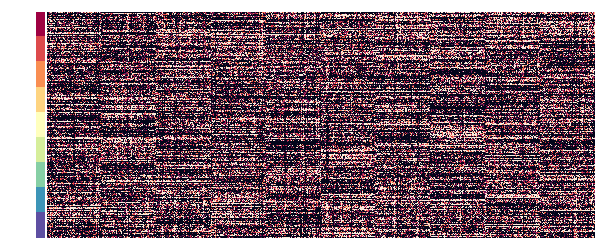

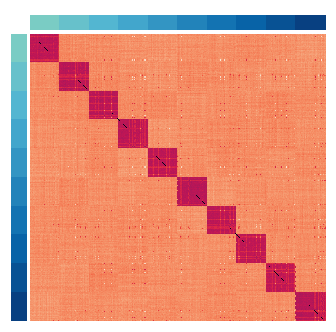

In [17]:
from plot_utils import plot_by_noise_struct
plot_by_noise_struct(var_df, lam_true, x, num_grps = 10)

In [18]:
# TODO:
# 1. run g-aloe on this to make sure the correct variables are selected
# 2. fit splines on the selected variables (using spline fit) -> feat_viz
# 3. collect the parameter matrix -> feat_viz
from main_methods import run_procedure
from sim_utils import selction_eval

result = run_procedure(z, x, sim_params['method_params'])
selction_eval(result, lam_true, sim_params, var_df)
result.keys()

{'FDP': 0.025279247501469725, 'Power': 0.9910340705319785, 'Corr': 0.9950108920048409, 'Num_Nonnulls': 1673, 'Num_Rejections': 1701}


dict_keys(['lam_init', 'lam_update', 'p_vals', 'rejections'])

In [19]:
# fit the spline with updated lambda and the x features
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin

# get the variable group ids
lam = result["lam_update"]
base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, x, base_args)

cr(x, knots=(-0.012, 0.013))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters


In [22]:
import umap
from plot_utils import plot_scatter_discrete
def compute_embedding(mtx, sel_idx=None):
    uobj = umap.UMAP(random_state=10101)
    if sel_idx is None:
        sel_idx = np.arange(mtx.shape[0])
    print("input dimension: {}".format(mtx[sel_idx, :].shape))
    embedding = uobj.fit_transform(mtx[sel_idx, :])
    df = pd.DataFrame(embedding, columns=["umap 1", "umap 2"])
    df["id"] = sel_idx
    return df

def compute_all_embeddings(c_mtx, x):
    embed_dict = {}
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    for sel in sel_list:
        if sel == "rejected":
            sel_idx = result["rejections"]
        else:
            sel_idx = None
        for mat in mat_list:
            if mat == "coeffient":
                in_mtx = c_mtx
            else:
                in_mtx = x.T
            key = "{}_{}".format(sel, mat)
            print("Computing embedding for: {}".format(key))
            df = compute_embedding(in_mtx, sel_idx=sel_idx)
            embed_dict[key] = df
    return embed_dict

embed_dict = compute_all_embeddings(c_mtx, x)

Computing embedding for: all_coeffient
input dimension: (5994, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: all_expression
input dimension: (5994, 1500)
Computing embedding for: rejected_coeffient
input dimension: (1701, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: rejected_expression
input dimension: (1701, 1500)


Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})


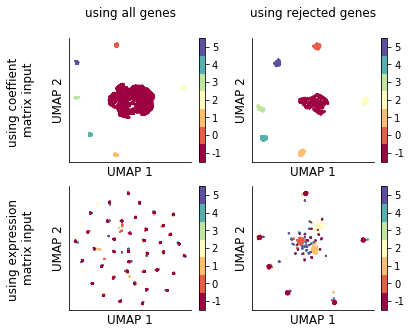

In [23]:
from collections import Counter
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fontsize = 12
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        var_labs = var_df.loc[plt_df["id"]]['nn_grp'].values
        print("{}".format(Counter(var_labs)))
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
# plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
plt.show()

In [ ]:
# create feature data frame
map_idx

def save_init_data(sim_params, lam, z, x):
    dat_dir = sim_params['sim_dir']
    os.makedirs(dat_dir, exist_ok = True)
    # save parameters to file
    fn_param = os.path.join(dat_dir, 'sim_params.json')
    save_data_to_file(sim_params, fn_param, "json")
    print('Saving data to {}'.format(dat_dir))
    var = {'lam': lam, 'x': x, 'z': z}
    for v in var:
        fn = os.path.join(dat_dir, '{}.npy'.format(v))
        dat = var[v]
        save_data_to_file(dat, fn, 'npy')
        print('Saved {} {}'.format(v, dat.shape))

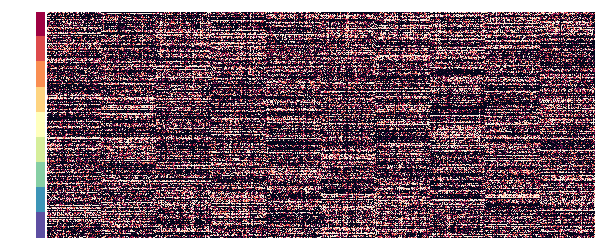

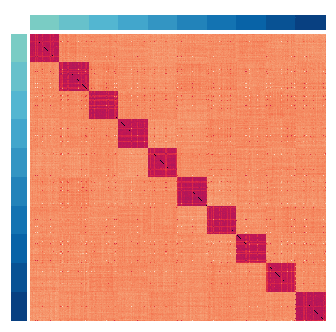

In [8]:
from plot_utils import create_color_map
from sklearn.metrics import pairwise_distances

num_grps = 10
grp_size = sim_params['null_struct']['block_size']
grps = np.arange(num_grps)
grp_ids = np.repeat(grps,  grp_size)
lut = create_color_map(grps, "GnBu", start=0.5, end=1)
corr_cols = mtx[:, map_idx][:, :grp_size*num_grps]
plot_ground_truth_heatmap(lam_true, corr_cols)
dist_feat = pairwise_distances(corr_cols.T, metric="euclidean") ** 2
plot_col_color_heatmap(dist_feat, grp_ids, lut, square=True)

In [10]:
# TODO:
# 1. run g-aloe on this to make sure the correct variables are selected
# 2. fit splines on the selected variables (using spline fit) -> feat_viz
# 3. collect the parameter matrix -> feat_viz
from main_methods import run_procedure
from sim_utils import selction_eval, get_variable_group_ids
meth_params = sim_params['method_params']
result = run_procedure(z, x, meth_params)
result.keys()

[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...


dict_keys(['lam_init', 'lam_update', 'p_vals', 'rejections'])

In [11]:
selction_eval(result, lam_true, sim_params, new_nn_idx)
var_ids = get_variable_group_ids(sim_params)

{'FDP': 0.025279247501469725, 'Power': 0.9940047961630696, 'Corr': 0.9950108920048409, 'Num_Nonnulls': 1668, 'Num_Rejections': 1701}


In [12]:
# fit the spline with updated lambda and the x features
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin

# get the variable group ids
lam = result["lam_update"]
base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, x, base_args)

cr(x, knots=(-0.012, 0.013))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters


In [13]:
import umap
from plot_utils import plot_scatter_discrete
def compute_embedding(mtx, var_names, sel_idx=None):
    assert mtx.shape[0] == len(var_names), "dim mismatch"
    uobj = umap.UMAP(random_state=10101)
    if sel_idx is None:
        sel_idx = np.arange(len(var_names))
    print("input dimension: {}".format(mtx[sel_idx, :].shape))
    embedding = uobj.fit_transform(mtx[sel_idx, :])
    df = pd.DataFrame(embedding, columns=["umap 1", "umap 2"])
    df["id"] = sel_idx
    df["var"] = var_names[sel_idx]
    return df

def compute_all_embeddings(c_mtx, x):
    embed_dict = {}
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    for sel in sel_list:
        if sel == "rejected":
            sel_idx = result["rejections"]
        else:
            sel_idx = None
        for mat in mat_list:
            if mat == "coeffient":
                in_mtx = c_mtx
            else:
                in_mtx = x.T
            key = "{}_{}".format(sel, mat)
            print("Computing embedding for: {}".format(key))
            df = compute_embedding(in_mtx, var_ids, sel_idx=sel_idx)
            embed_dict[key] = df
    return embed_dict

embed_dict = compute_all_embeddings(c_mtx, x)

Computing embedding for: all_coeffient
input dimension: (5994, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: all_expression
input dimension: (5994, 1500)
Computing embedding for: rejected_coeffient
input dimension: (1701, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: rejected_expression
input dimension: (1701, 1500)


Counter({-1.0: 5094, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
Counter({-1.0: 5094, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
Counter({-1.0: 810, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 5.0: 147, 4.0: 144})
Counter({-1.0: 810, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 5.0: 147, 4.0: 144})


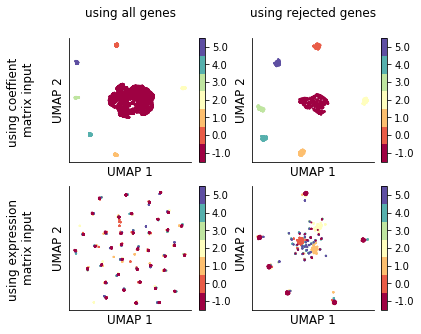

In [16]:
from collections import Counter
fontsize = 12
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        var_labs = plt_df["var"]
        print("{}".format(Counter(var_labs)))
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
# plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
plt.show()

# Corr = 0.5

[feat_viz INFO] Counter({-1.0: 5094, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({-1.0: 5094, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({-1.0: 833, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 147, 5.0: 147})
[feat_viz INFO] Counter({-1.0: 833, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 147, 5.0: 147})


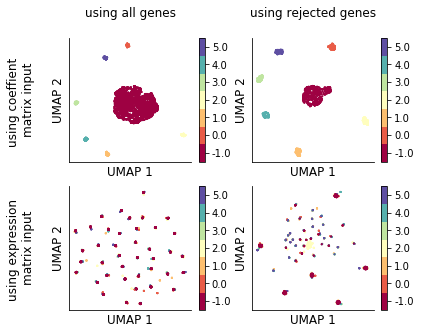

In [10]:
from collections import Counter
fontsize = 12
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        var_labs = plt_df["var"]
        logger.info("{}".format(Counter(var_labs)))
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
# plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
plt.show()